In [1]:
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
from sklearn import preprocessing

path="Data//"

taux_interet =pd.read_csv('Data//taux_interet.csv',sep=',',parse_dates=['date'])
taux_endettement =pd.read_csv('Data//taux_endettement.csv',sep=',',)
parc=pd.read_csv(path+'parc_immobilier.csv',sep=',')

foyer_fiscaux=pd.read_csv(path+'foyers_fiscaux.csv',sep=',')

## Objectifs:

L'objectifs du modèle sera de faire des prédictions de prix de ventes des <b>appartements</b>.
On pourra effectuer ces prédictions à partir des informations suivantes:

Variable cible : prix

features: Quartier,Surface habitable carrez, n_pieces, Ancien/Neuf, 


Le marché de l'immobilier étant assez volatile, on realisera des prédiction en prenant une fenêtre de temps glissante à partir de la date de départ séléctionné par l'utilisateur.


## Macro structure:


IHM pour l'utilisateurs (Streamlit?) dans lequel on enverra:<ul>

<li>surface (intervalle)
<li>Neuf/ancien
<li>nb_pièces
<li>Diagnostic Performance Energétique
<li>Année de construction du batiment
</ul>

Sur la base de ces critères, on constitue une sous dataset pertinent pour effectuer une prédiction de type regression linéaire.


On renvoi cette prédiction à l'utilisateur.

## Transactions

In [2]:
# ---- /!\ A exécuter une fois /!\ ------------
arrays = dict(np.load("Data//transactions.npz"))

data = {k: [s.decode("utf-8") for s in v.tobytes().split(b"\x00")] if v.dtype == np.uint8 else v for k, v in arrays.items()}
transactions = pd.DataFrame.from_dict(data)

transactions=transactions[transactions['date_transaction']>dt.datetime(2018, 12, 31)]
#transactions.to_csv('transactions_since_2019.csv',sep=',',index=False)
#transactions =pd.read_csv('transactions_since_2019.csv',sep=',',parse_dates=['date_transaction'])

transactions=transactions[transactions['type_batiment']=='Appartement']

### Exemple sur Grenoble

In [3]:
#on prend les 1500 derniers transactions de Grenoble
transactions_gre=transactions[transactions['ville']=='GRENOBLE'].tail(1500)
transactions_gre.set_index('id_transaction',inplace=True)
transactions_gre['Q']=transactions_gre.date_transaction.apply(lambda x: x.to_period('Q'))

transactions_gre.head()

,date_transaction,prix,departement,id_ville,ville,code_postal,adresse,type_batiment,vefa,n_pieces,surface_habitable,id_parcelle_cadastre,latitude,longitude,surface_dependances,surface_locaux_industriels,surface_terrains_agricoles,surface_terrains_sols,surface_terrains_nature,Q
id_transaction,,,,,,,,,,,,,,,,,,,,
3942121,2021-07-26,317000.0,38,185,GRENOBLE,38100,51 BD MAL FOCH,Appartement,False,5,119,38185000DL0009,45.180189,5.718156,"{0,0}",{},{},{},{},2021Q3
3940409,2021-07-27,217200.0,38,185,GRENOBLE,38000,7 PL GUSTAVE RIVET,Appartement,False,4,75,38185000DH0010,45.181629,5.728093,{0},{},{},{},{},2021Q3
3935160,2021-07-27,232750.0,38,185,GRENOBLE,38000,46 BD MAL FOCH,Appartement,False,4,88,38185000DI0068,45.181013,5.721334,{0},{},{},{},{},2021Q3
3935508,2021-07-27,124500.0,38,185,GRENOBLE,38100,55 AV JEAN PERROT,Appartement,False,3,68,38185000DT0376,45.177681,5.736912,{0},{},{},{},{},2021Q3
3940690,2021-07-27,162000.0,38,185,GRENOBLE,38000,68 BD GAMBETTA,Appartement,False,2,54,38185000DI0036,45.182224,5.726824,"{0,0}",{},{},{},{},2021Q3


### Prétraitement taux intéret

In [4]:
from sklearn import preprocessing
def preprocess_taux_interet(nom,path,profondeur): 

    #import
    taux_interet =pd.read_csv(path+nom,sep=',',parse_dates=['date'])
    #on supprime les valeurs na
    taux_interet=taux_interet[(~taux_interet['taux_10_20_ans'].isna())&(~taux_interet['taux_20_plus_ans'].isna())][['date','taux_10_20_ans','taux_20_plus_ans']]
    #on conservera que le crédit de 10 ans et plus
    taux_interet['taux moyen']=taux_interet.apply(lambda x: (x['taux_10_20_ans']+x['taux_20_plus_ans'])/2,axis=1)
    #extraction de l'année
    taux_interet['y']=taux_interet.date.apply(lambda x: x.year)
    #on filtre que les années les plus récentes
    taux_interet=taux_interet[taux_interet['y']>=(dt.date.today().year-profondeur)]
    
    #normalisation
    transformer = preprocessing.MinMaxScaler().fit(taux_interet[['taux moyen']])
    X_transformed = transformer.transform(taux_interet[['taux moyen']])
    temp=pd.DataFrame({'Taux_interet_norma': X_transformed[:,0]})
    taux_interet=pd.concat([taux_interet[['date','y']],temp],axis=1)
    taux_interet['Taux_interet_norma']=taux_interet['Taux_interet_norma'].apply(lambda x: round(x,3))

    taux_interet.sort_values(by=["date"],ascending=False,inplace=True)

    taux_interet['Q']=taux_interet.date.apply(lambda x:x.to_period('Q'))
    taux_interet=taux_interet[['Q','Taux_interet_norma']]
    return taux_interet

#jointure possible entre transactions et taux_interet

In [5]:
name_taux='taux_interet.csv'
taux_interet=preprocess_taux_interet(name_taux,path,3)


## Prétraitement logement vacant


In [6]:

def preprocess_logement_vac(nom,path): 

    year=dt.date.today().year
    
    #import
    parc=pd.read_csv(path+nom,sep=',')
    
    #supprimer les valeurs na
    parc=parc[(~parc['n_logements'].isna())&(~parc['n_logements_vacants'].isna())]
    
    #calculer le % d'occupation
    parc['perc_vacant']=parc.apply(lambda x: round(x['n_logements_vacants']/x['n_logements'],4)*100, axis=1)
    
    # les valeurs na sont remplacer par la moyenne du département
    parc_na=parc.groupby(['date','departement']).agg({'perc_vacant':'mean'}).reset_index()
    parc_na.rename(columns={'perc_vacant':'perc_vacant_na'},inplace=True)

    parc=parc.merge(parc_na,how='inner',on=['date','departement'])
    parc.perc_vacant.fillna(parc['perc_vacant_na'],inplace=True)

    parc=parc[['date','id_ville','ville','departement','perc_vacant']]
    
    return parc



In [7]:
parc_name='parc_immobilier.csv'
parc=preprocess_logement_vac(parc_name,path)


## Prétraitement Foyer fiscaux

In [8]:

def preprocess_Foyer_fiscaux(nom,path,profondeur):  
    year=dt.date.today().year
    #import
    foyer_fiscaux=pd.read_csv(path+nom,sep=',')
    
    #filtre sur les données inferieur à un certains nombre d'année
    foyer_fiscaux=foyer_fiscaux[foyer_fiscaux['date']>=year-(profondeur)]

    # les valeurs na sont remplacer par la moyenne du département
    foyer_fiscaux_na=foyer_fiscaux.groupby(['date','departement']).agg({'revenu_fiscal_moyen':'mean'}).reset_index()
    foyer_fiscaux_na=foyer_fiscaux_na.astype({'date':'int64','departement':str})

    foyer_fiscaux_na.rename(columns={'revenu_fiscal_moyen':'revenu_fiscal_moyen_na'},inplace=True)

    foyer_fiscaux_na.dtypes
    foyer_fiscaux=foyer_fiscaux.merge(foyer_fiscaux_na[['date','departement','revenu_fiscal_moyen_na']],how='inner',on=['date','departement'])
    foyer_fiscaux.revenu_fiscal_moyen.fillna(foyer_fiscaux['revenu_fiscal_moyen_na'],inplace=True)
    foyer_fiscaux=foyer_fiscaux[['date','id_ville','ville','departement','revenu_fiscal_moyen']]

    return foyer_fiscaux


In [9]:
foyer_fiscaux_name='foyers_fiscaux.csv'

foyer_fiscaux=preprocess_Foyer_fiscaux(foyer_fiscaux_name,path,3)

## Exemple sur un sous dataset : Grenoble

In [10]:
#compilation du dataset final

transactions_gre['departement']=transactions_gre.departement.astype(str)
final=transactions_gre.merge(foyer_fiscaux[['id_ville','departement','revenu_fiscal_moyen']],how='left',on=['departement','id_ville']).merge(parc[['id_ville','departement','perc_vacant']],how='left',on=['departement','id_ville']).merge(taux_interet[['Q','Taux_interet_norma']],how='left',on='Q')
final.sort_values(by='date_transaction',ascending=False,inplace=True)
final.head()

,date_transaction,prix,departement,id_ville,ville,code_postal,adresse,type_batiment,vefa,n_pieces,...,longitude,surface_dependances,surface_locaux_industriels,surface_terrains_agricoles,surface_terrains_sols,surface_terrains_nature,Q,revenu_fiscal_moyen,perc_vacant,Taux_interet_norma
1499,2022-06-30,96500.0,38,185,GRENOBLE,38100,24 RUE LE BRIX,Appartement,False,2,...,5.720997,{0},{},{},{},{},2022Q2,24238.12,12.94,0.162
1498,2022-06-30,52000.0,38,185,GRENOBLE,38100,5 RUE ALFRED DE MUSSET,Appartement,False,1,...,5.726609,{},{},{},{},{},2022Q2,24238.12,12.94,0.162
1497,2022-06-30,157730.0,38,185,GRENOBLE,38100,14 AV RHIN ET DANUBE,Appartement,False,4,...,5.704229,{0},{},{},{},{},2022Q2,24238.12,12.94,0.162
1496,2022-06-30,294200.0,38,185,GRENOBLE,38100,167 RUE DE STALINGRAD,Appartement,False,5,...,5.723956,{0},{},{},{},{},2022Q2,24238.12,12.94,0.162
1495,2022-06-30,179000.0,38,185,GRENOBLE,38100,65 RUE JOSEPH BOUCHAYER,Appartement,False,4,...,5.707557,{0},{},{},{},{},2022Q2,24238.12,12.94,0.162


## IRIS code
on va déterminer l'IRIS Code grâce à la position GPS (latitude et longitude).


On utilise une API mis à disposition pour obtenir l'IRIS CODE: https://pyris.datajazz.io/doc/

On pourra par la suite réaliser des prédictions sur le quartier (=IRIS CODE) associé au bien que l'utilisateur souhaite estimer


In [11]:
import requests
def get_IRIS_CODE_FROM_LAT_LONG(lat,long):  

    lat=str(lat)
    long=str(long)
    r = requests.get('https://pyris.datajazz.io/api/coords?geojson=false&lat='+lat+'&lon='+long+'')
    status_code = r.status_code
    
    if(status_code==200):    
        response_dict = r.json()
        code=response_dict['complete_code']+'/'+response_dict['city']+'_'+response_dict['name']
    else:
        code=None   

    return code


In [13]:
final['IRIS_CODE']=final.apply(lambda x: None if (pd.isna(x['latitude']) | pd.isna(x['longitude'])) else get_IRIS_CODE_FROM_LAT_LONG(x['latitude'],x['longitude']),axis=1)


In [14]:
final['Quartier']=final.IRIS_CODE.apply(lambda x: x.split('/')[1])
final['IRIS_CODE']=final.IRIS_CODE.apply(lambda x: x.split('/')[0])
final.head()

,date_transaction,prix,departement,id_ville,ville,code_postal,adresse,type_batiment,vefa,n_pieces,...,surface_locaux_industriels,surface_terrains_agricoles,surface_terrains_sols,surface_terrains_nature,Q,revenu_fiscal_moyen,perc_vacant,Taux_interet_norma,IRIS_CODE,Quartier
1499,2022-06-30,96500.0,38,185,GRENOBLE,38100,24 RUE LE BRIX,Appartement,False,2,...,{},{},{},{},2022Q2,24238.12,12.94,0.162,381850401,Grenoble_Foch Ouest
1498,2022-06-30,52000.0,38,185,GRENOBLE,38100,5 RUE ALFRED DE MUSSET,Appartement,False,1,...,{},{},{},{},2022Q2,24238.12,12.94,0.162,381850608,Grenoble_Vigny-Musset
1497,2022-06-30,157730.0,38,185,GRENOBLE,38100,14 AV RHIN ET DANUBE,Appartement,False,4,...,{},{},{},{},2022Q2,24238.12,12.94,0.162,381850301,Grenoble_Drac-Ampere
1496,2022-06-30,294200.0,38,185,GRENOBLE,38100,167 RUE DE STALINGRAD,Appartement,False,5,...,{},{},{},{},2022Q2,24238.12,12.94,0.162,381850412,Grenoble_Allies-Clos d'Or
1495,2022-06-30,179000.0,38,185,GRENOBLE,38100,65 RUE JOSEPH BOUCHAYER,Appartement,False,4,...,{},{},{},{},2022Q2,24238.12,12.94,0.162,381850305,Grenoble_Eaux Claires-Champs Elysees


In [15]:
final.Quartier.value_counts(normalize=True)

#on fait le choix de prendre le quartier Championnet

Grenoble_Vigny-Musset         0.053333
Grenoble_Championnet          0.034000
Grenoble_Foch Ouest           0.031333
Grenoble_Saint-Andre          0.027333
Grenoble_Gabriel Peri         0.026667
                                ...   
Grenoble_Constantine          0.004000
Grenoble_Hebert-Mutualite     0.003333
Grenoble_Jouhaux              0.002000
Grenoble_Helbronner-Geants    0.001333
Grenoble_Mistral              0.000667
Name: Quartier, Length: 65, dtype: float64

In [17]:
#Test quartier Championnet de Grenoble
transactions_gre_champ=final[(final['Quartier']=='Grenoble_Championnet')]

#transactions_gre_champ.to_csv('transactions_gre_IRIS.csv',sep=';',index=False)

## Modélisation


Algorithme à tester:<ul>
<li>regression lineaire
<li>random forest regressor
<li>support vector
</ul>

    
Metrique à utiliser:<ul>
<li>mean absolute error
<li>median absolute error
</ul>


Le choix de la métrique peut être à ajuster si la dispersion est trés importante sur le sous dataset:<ul>
    <li>mean absolute error lorsque faible dispersion (à définir)
    <li>median absolute error lorsque la dispersion est forte (à définir)

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error,median_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
import seaborn as sns


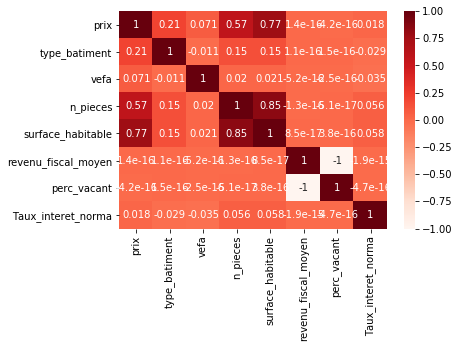

In [21]:
transac_gre_champ=pd.read_csv('transactions_gre_IRIS.csv',sep=';')
X=transac_gre_champ.drop(['date_transaction','departement','id_ville','code_postal','ville','departement','adresse','latitude','longitude','Q','IRIS_CODE','Quartier'],axis=1)
X = X.replace({"Appartement":0, "Maison":1})
X["vefa"] = X["vefa"].astype(int)

sns.heatmap(X.corr(), annot=True, cmap='Reds')

#Sans surprise, on voit une forte corrélation prix / surface 

In [22]:
#Séparation cible et features
y=X.prix
X=X.drop(['prix'],axis=1)

In [23]:
def perf_prix (X,y,model):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    mae=-1
    med=-1
    
    for m in model:
        m.fit(X_train,y_train)
        pred=m.predict(X_test)
        mae_temp=mean_absolute_error(pred,y_test)
        #med_temp=median_absolute_error(pred,y_test)
        
        if ((mae ==-1) | (mae_temp<mae)):
            mae=mae_temp
            best_model=m
        
    return mae,best_model

In [26]:
model_reg=[]

svr = SVR(kernel='rbf')
knn= KNeighborsRegressor(n_neighbors=10)
lr = LinearRegression()
rfr = RandomForestRegressor(max_depth=2, random_state=0)


model_reg.append(svr)
model_reg.append(knn)
model_reg.append(lr)
model_reg.append(rfr)



print('La meilleur performance a une erreur absolue moyenne de :',perf_prix(X,y,model_reg)[0])

print('Le meilleur estimateur est: ',type(perf_prix(X,y,model_reg)[1]))

La meilleur performance a une erreur absolue moyenne de : 35288.40037235047
Le meilleur estimateur est:  <class 'sklearn.linear_model._base.LinearRegression'>
